In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import re, time
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = 20

In [3]:
url = "https://berlin.kauperts.de/Strassenverzeichnis"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "html.parser")

In [4]:
web_download = []
for x in soup.find_all("a", href = True):
    web_download.append(x["href"])

In [5]:
berlin = pd.DataFrame(pd.Series(web_download[37:-14]).str.split("/").str[4], columns = ["Neighborhood"])
berlin.head(10)

,Neighborhood
0,NaN
1,Charlottenburg
2,Charlottenburg-Nord
3,Grunewald
4,Halensee
5,Schmargendorf
6,Westend
7,Wilmersdorf
8,NaN
9,Friedrichshain


In [6]:
neighborhood_borough = []

for x in range(len(berlin)):
    neighborhood_borough.append(berlin.iloc[0:x, 0].isna().sum() - 1)

neighborhood_borough = neighborhood_borough[1:]
neighborhood_borough.append(berlin.iloc[0:x, 0].isna().sum() - 1)

neighborhood_borough[0:5]

[0, 0, 0, 0, 0]

In [7]:
berlin["borough_index"] = neighborhood_borough
berlin.head()

,Neighborhood,borough_index
0,NaN,0
1,Charlottenburg,0
2,Charlottenburg-Nord,0
3,Grunewald,0
4,Halensee,0


In [8]:
borough = pd.DataFrame(soup.find_all("a", class_ = "district-name"), columns = ["Borough"])["Borough"].to_dict()
borough[4] = "Berlin-Mitte"
borough

{0: 'Charlottenburg-Wilmersdorf',
 1: 'Friedrichshain-Kreuzberg',
 2: 'Lichtenberg',
 3: 'Marzahn-Hellersdorf',
 4: 'Berlin-Mitte',
 5: 'Neukölln',
 6: 'Pankow',
 7: 'Reinickendorf',
 8: 'Spandau',
 9: 'Steglitz-Zehlendorf',
 10: 'Tempelhof-Schöneberg',
 11: 'Treptow-Köpenick'}

In [9]:
berlin["Borough"] = berlin["borough_index"].map(borough)
berlin.drop(columns = "borough_index", inplace = True)
berlin = berlin.loc[berlin["Neighborhood"].notna(), :].reset_index(drop = True)
berlin

,Neighborhood,Borough
0,Charlottenburg,Charlottenburg-Wilmersdorf
1,Charlottenburg-Nord,Charlottenburg-Wilmersdorf
2,Grunewald,Charlottenburg-Wilmersdorf
3,Halensee,Charlottenburg-Wilmersdorf
4,Schmargendorf,Charlottenburg-Wilmersdorf
...,...,...
91,Niederschoeneweide,Treptow-Köpenick
92,Oberschoeneweide,Treptow-Köpenick
93,Plaenterwald,Treptow-Köpenick
94,Rahnsdorf,Treptow-Köpenick


In [10]:
prices = pd.read_csv("price_berlin.csv", usecols = [0, 10]).rename(columns = {"Bezirk": "Borough", "Q1 2019": "Price"})
prices["Price"] = (prices["Price"] * 1000).astype(int)
prices.loc[prices["Borough"] == "Mitte", "Borough"] = "Berlin-Mitte"
prices.head(12)

,Borough,Price
0,Charlottenburg-Wilmersdorf,4856
1,Berlin-Mitte,4693
2,Friedrichshain-Kreuzberg,4555
3,Pankow,4467
4,Steglitz-Zehlendorf,4068
5,Tempelhof-Schöneberg,4031
6,Neukölln,3758
7,Lichtenberg,3585
8,Reinickendorf,3053
9,Treptow-Köpenick,3013


In [11]:
url = "https://www.citypopulation.de/de/germany/berlin/admin/"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "html")

In [12]:
soup1 = soup.find_all(itemprop="name")[3:]
del soup1[57]
soup2 = soup.find_all(class_="rpop prio1")[1:-1]

In [13]:
people = pd.merge(pd.DataFrame(soup1), pd.DataFrame(soup2), left_index = True, right_index = True)
people.columns = ["Borough", "People"]
people["People"] = people["People"].replace("\.", "", regex = True).astype(int)
people["Borough"] = people["Borough"].str.replace(" ", "")
people.sort_values("People", ascending = False, inplace = True)
people.drop_duplicates(subset = "Borough", keep = "first", inplace = True)
people["isin"] = people["Borough"].isin(prices["Borough"])
people = people.loc[people["isin"] == True, ["Borough", "People"]].reset_index(drop = True)
people

,Borough,People
0,Pankow,409335
1,Berlin-Mitte,385748
2,Tempelhof-Schöneberg,350984
3,Charlottenburg-Wilmersdorf,343592
4,Neukölln,329917
5,Steglitz-Zehlendorf,310071
6,Lichtenberg,294201
7,Friedrichshain-Kreuzberg,290386
8,Treptow-Köpenick,273689
9,Marzahn-Hellersdorf,269967


In [14]:
berlin_borough = pd.merge(prices, people, on = "Borough", how = "left")
berlin_borough

,Borough,Price,People
0,Charlottenburg-Wilmersdorf,4856,343592
1,Berlin-Mitte,4693,385748
2,Friedrichshain-Kreuzberg,4555,290386
3,Pankow,4467,409335
4,Steglitz-Zehlendorf,4068,310071
5,Tempelhof-Schöneberg,4031,350984
6,Neukölln,3758,329917
7,Lichtenberg,3585,294201
8,Reinickendorf,3053,266408
9,Treptow-Köpenick,3013,273689


In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

In [17]:
def scale(series):
    X = np.array(series).reshape(-1, 1)
    scaler.fit(X)
    column = scaler.transform(X)

    return(column)

In [18]:
berlin_borough["Price_Scaled"] = scale(berlin_borough["Price"]).round(2)
berlin_borough["People_Scaled"] = scale(berlin_borough["People"]).round(2)

In [19]:
berlin_borough

,Borough,Price,People,Price_Scaled,People_Scaled
0,Charlottenburg-Wilmersdorf,4856,343592,1.41,0.61
1,Berlin-Mitte,4693,385748,1.19,1.48
2,Friedrichshain-Kreuzberg,4555,290386,1.01,-0.49
3,Pankow,4467,409335,0.90,1.96
4,Steglitz-Zehlendorf,4068,310071,0.38,-0.08
5,Tempelhof-Schöneberg,4031,350984,0.33,0.76
6,Neukölln,3758,329917,-0.03,0.33
7,Lichtenberg,3585,294201,-0.25,-0.41
8,Reinickendorf,3053,266408,-0.94,-0.98
9,Treptow-Köpenick,3013,273689,-1.00,-0.83


In [20]:
import seaborn as sns

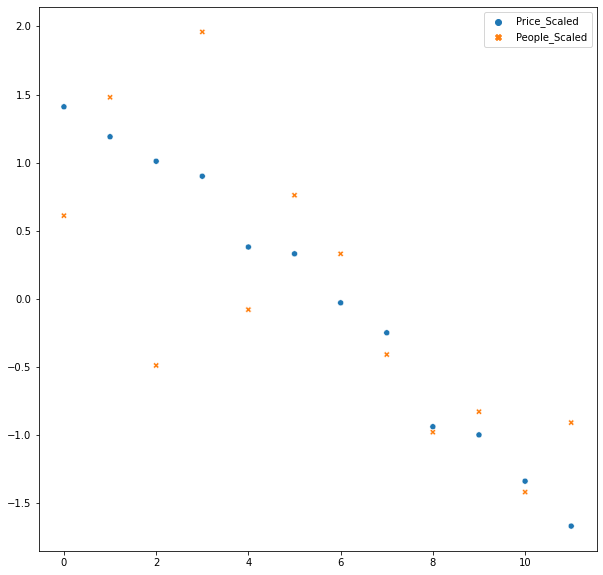

In [21]:
plt.figure(figsize = (10, 10))
scatter = sns.scatterplot(data = berlin_borough[["Price_Scaled", "People_Scaled"]])

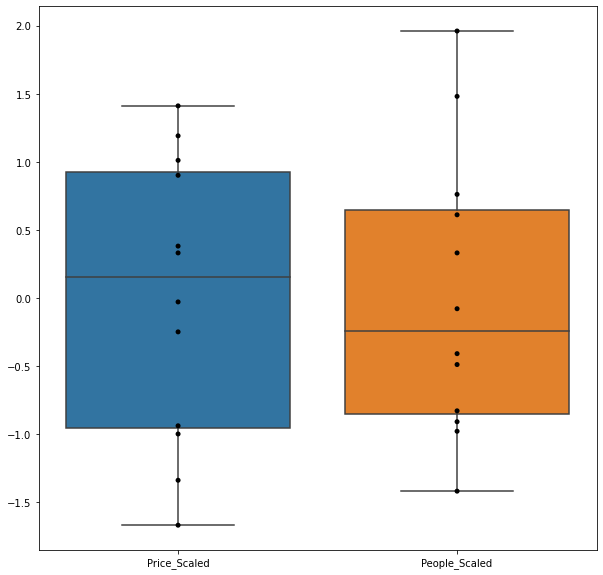

In [22]:
plt.figure(figsize = (10, 10))
bp = sns.boxplot(data = berlin_borough[["Price_Scaled", "People_Scaled"]])
bp = sns.swarmplot(data = berlin_borough[["Price_Scaled", "People_Scaled"]], color = "0.0")

In [23]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

In [24]:
geolocator = Nominatim(user_agent = "coursera_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 1.1)

latitude_list = []
longitude_list = []

for neighborhood in range(len(berlin)):
    location = geolocator.geocode(berlin.iloc[neighborhood, 0] + " ,Berlin", timeout = 10)
    if location == None:
        latitude = np.nan
        longitude = np.nan
    else:
        latitude = location.latitude
        longitude = location.longitude
    latitude_list.append(latitude)
    longitude_list.append(longitude)

latitude = pd.Series(latitude_list)
longitude = pd.Series(longitude_list)

In [25]:
print(latitude.isna().sum())
print(longitude.isna().sum())

0
0


In [26]:
berlin["Latitude"] = latitude.values
berlin["Longitude"] = longitude.values
berlin.head()

,Neighborhood,Borough,Latitude,Longitude
0,Charlottenburg,Charlottenburg-Wilmersdorf,52.515747,13.309683
1,Charlottenburg-Nord,Charlottenburg-Wilmersdorf,52.540525,13.296266
2,Grunewald,Charlottenburg-Wilmersdorf,52.460482,13.238699
3,Halensee,Charlottenburg-Wilmersdorf,52.497226,13.292999
4,Schmargendorf,Charlottenburg-Wilmersdorf,52.478902,13.292996


In [27]:
def get_coordinates(place):
    address_place = place
    location = geolocator.geocode(address_place, timeout = 10)
    latitude = location.latitude
    longitude = location.longitude
    return(latitude, longitude)

In [28]:
import folium
from folium import plugins

In [29]:
fill_colors = ['black', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple']
colors_dict = dict(zip(list(berlin["Borough"].unique()), fill_colors))
colors_dict

{'Charlottenburg-Wilmersdorf': 'black',
 'Friedrichshain-Kreuzberg': 'blue',
 'Lichtenberg': 'green',
 'Marzahn-Hellersdorf': 'purple',
 'Berlin-Mitte': 'orange',
 'Neukölln': 'darkred',
 'Pankow': 'lightred',
 'Reinickendorf': 'beige',
 'Spandau': 'darkblue',
 'Steglitz-Zehlendorf': 'darkgreen',
 'Tempelhof-Schöneberg': 'cadetblue',
 'Treptow-Köpenick': 'darkpurple'}

In [30]:
berlin["fill_color"] = berlin["Borough"].map(colors_dict)

In [31]:
def remove_umlaute(df):
    df["Neighborhood"] = df["Neighborhood"].str.replace("ä", "ae")
    df["Neighborhood"] = df["Neighborhood"].str.replace("ö", "oe")
    df["Neighborhood"] = df["Neighborhood"].str.replace("ü", "ue")
    df["Borough"] = df["Borough"].str.replace("ä", "ae")
    df["Borough"] = df["Borough"].str.replace("ö", "oe")
    df["Borough"] = df["Borough"].str.replace("ü", "ue")
    return(df)

In [32]:
berlin = remove_umlaute(berlin)

In [33]:
map_berlin = folium.Map(location = [get_coordinates("Berlin, Germany")[0], get_coordinates("Berlin, Germany")[1]], zoom_start = 11)

for lat, lng, borough, neighborhood, color in zip(berlin['Latitude'], berlin['Longitude'], berlin["Borough"], berlin["Neighborhood"], berlin["fill_color"]):
    folium.Marker(
        location = [lat, lng],
        icon = folium.Icon(color = color),
        popup = "{}, {}".format(borough, neighborhood)
    ).add_to(map_berlin)

map_berlin

In [34]:
import requests
from pandas.io.json import json_normalize

In [35]:
CLIENT_ID = '3WBEZJF1MOQYJPJIPHJ2R5CSORYSCFCWO2HWBE55DJJNYCLU' # your Foursquare ID
CLIENT_SECRET = 'RL51MYTZRN40LR5SX4F4WDTMTGVIEVZGDAFK0KNO5HWFF1QB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    

    return(nearby_venues)

In [37]:
berlin_venues = getNearbyVenues(berlin["Neighborhood"], berlin["Latitude"], berlin["Longitude"])

Charlottenburg
Charlottenburg-Nord
Grunewald
Halensee
Schmargendorf
Westend
Wilmersdorf
Friedrichshain
Kreuzberg
Alt-Hohenschoenhausen
Falkenberg
Fennpfuhl
Friedrichsfelde
Karlshorst
Lichtenberg
Malchow
Neu-Hohenschoenhausen
Rummelsburg
Wartenberg
Biesdorf
Hellersdorf
Kaulsdorf
Mahlsdorf
Marzahn
Gesundbrunnen
Hansaviertel
Mitte
Moabit
Tiergarten
Wedding
Britz
Buckow
Gropiusstadt
Neukoelln
Rudow
Blankenburg
Blankenfelde
Buch
Franzoesisch-Buchholz
Heinersdorf
Karow
Niederschoenhausen
Pankow
Prenzlauer-Berg
Rosenthal
Stadtrandsiedlung-Malchow
Weissensee
Wilhelmsruh
Borsigwalde
Frohnau
Heiligensee
Hermsdorf
Konradshoehe
Luebars
Maerkisches-Viertel
Reinickendorf
Tegel
Waidmannslust
Wittenau
Falkenhagener-Feld
Gatow
Hakenfelde
Haselhorst
Kladow
Siemensstadt
Spandau
Staaken
Wilhelmstadt
Dahlem
Lankwitz
Lichterfelde
Nikolassee
Steglitz
Wannsee
Zehlendorf
Friedenau
Lichtenrade
Mariendorf
Marienfelde
Schoeneberg
Tempelhof
Adlershof
Alt-Treptow
Altglienicke
Baumschulenweg
Bohnsdorf
Friedrichshage

In [38]:
berlin_venues = pd.merge(berlin_venues, berlin[["Neighborhood", "Borough"]], on = "Neighborhood", how = "left")
print(berlin_venues.shape)
berlin_venues.head()

(1455, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
0,Charlottenburg,52.515747,13.309683,Trattoria Rathaus Piazza,52.516778,13.308748,Trattoria/Osteria,Charlottenburg-Wilmersdorf
1,Charlottenburg,52.515747,13.309683,Zur Mieze - Katzenmusikcafé,52.515899,13.304765,Pet Café,Charlottenburg-Wilmersdorf
2,Charlottenburg,52.515747,13.309683,Deutsche Oper Berlin,52.512088,13.308354,Opera House,Charlottenburg-Wilmersdorf
3,Charlottenburg,52.515747,13.309683,Postbank Finanzcenter,52.515821,13.312408,Bank,Charlottenburg-Wilmersdorf
4,Charlottenburg,52.515747,13.309683,Rogacki,52.512839,13.305050,Gourmet Shop,Charlottenburg-Wilmersdorf


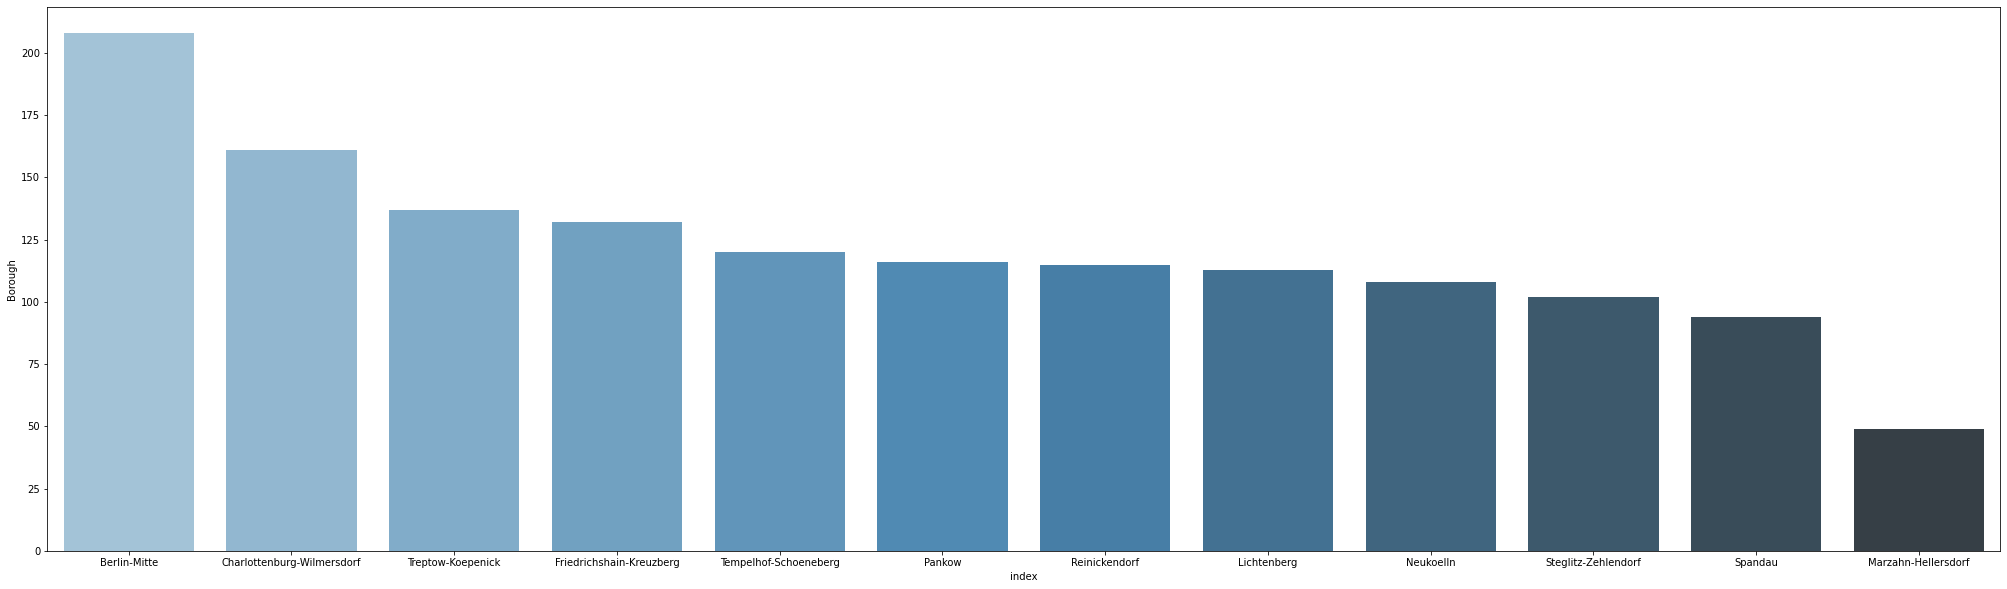

In [39]:
plt.figure(figsize = (35, 10))
bar = sns.barplot(x = "index", y = "Borough", data = pd.DataFrame(berlin_venues["Borough"].value_counts()).reset_index(), palette = "Blues_d")

In [40]:
berlin_venues[["Neighborhood", "Venue", "Venue Category"]].groupby(["Neighborhood", "Venue Category"]).count()

Venue
Neighborhood Venue Category           
Adlershof    Drugstore               1
             Greek Restaurant        1
             Italian Restaurant      1
             Steakhouse              1
             Supermarket             1
...                                ...
Zehlendorf   Pizza Place             1
             Steakhouse              1
             Supermarket             1
             Tree                    1
             Yoga Studio             1

[1116 rows x 1 columns]

In [41]:
berlin_venues[["Neighborhood", "Venue"]].groupby("Neighborhood").count()

,Venue
Neighborhood,
Adlershof,7
Alt-Hohenschoenhausen,9
Alt-Treptow,28
Altglienicke,1
Baumschulenweg,5
...,...
Wilhelmsruh,14
Wilhelmstadt,11
Wilmersdorf,47


In [42]:
print("There are {} unique categories in Berlin.".format(len(berlin_venues["Venue Category"].unique())))

There are 243 unique categories in Berlin.


In [43]:
berlin_venues[["Borough", "Venue", "Venue Category"]].groupby(["Borough", "Venue Category"]).count()

Venue
Borough           Venue Category              
Berlin-Mitte      Art Gallery                3
                  Art Museum                 3
                  Austrian Restaurant        1
                  BBQ Joint                  1
                  Bakery                     2
...                                        ...
Treptow-Koepenick Taverna                    1
                  Tram Station               4
                  Trattoria/Osteria          2
                  Turkish Restaurant         1
                  Vietnamese Restaurant      1

[740 rows x 1 columns]

In [44]:
berlin_venues["Venue Category"] = berlin_venues["Venue Category"].str.replace("Neighborhood", "Neighborhoods")

In [45]:
berlin_onehot = pd.get_dummies(berlin_venues[["Venue Category"]], prefix = "", prefix_sep = "")

berlin_onehot["Neighborhood"] = berlin_venues["Neighborhood"]

fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

print(berlin_onehot.shape)
berlin_onehot.head()

(1455, 244)


,Neighborhood,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Charlottenburg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
berlin_grouped = berlin_onehot.groupby("Neighborhood").mean().reset_index()
print(berlin_grouped.shape)
berlin_grouped

(94, 244)


,Neighborhood,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Adlershof,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Alt-Hohenschoenhausen,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Alt-Treptow,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,...,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Altglienicke,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Baumschulenweg,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,Wilhelmsruh,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
90,Wilhelmstadt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
91,Wilmersdorf,0.0,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,...,0.0,0.042553,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
92,Wittenau,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [47]:
num_top_venues = 5

for hood in berlin_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = berlin_grouped[berlin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adlershof----
                venue  freq
0           Drugstore  0.14
1    Greek Restaurant  0.14
2  Italian Restaurant  0.14
3          Steakhouse  0.14
4        Tram Station  0.14


----Alt-Hohenschoenhausen----
               venue  freq
0  Indian Restaurant  0.11
1        Supermarket  0.11
2   Greek Restaurant  0.11
3       Tram Station  0.11
4        Coffee Shop  0.11


----Alt-Treptow----
                venue  freq
0              Bakery  0.07
1            Platform  0.07
2  Italian Restaurant  0.07
3       Garden Center  0.04
4    Tapas Restaurant  0.04


----Altglienicke----
                  venue  freq
0          Home Service   1.0
1                   ATM   0.0
2  Pakistani Restaurant   0.0
3             Multiplex   0.0
4                Museum   0.0


----Baumschulenweg----
              venue  freq
0       Supermarket   0.4
1    Ice Cream Shop   0.2
2  Asian Restaurant   0.2
3         Drugstore   0.2
4               ATM   0.0


----Biesdorf----
                venue  freq

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = berlin_grouped['Neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Drugstore,Steakhouse,Tram Station,Trattoria/Osteria,Supermarket,Italian Restaurant,Greek Restaurant,Fast Food Restaurant,Fish & Chips Shop,Farmers Market
1,Alt-Hohenschoenhausen,Indian Restaurant,Coffee Shop,Big Box Store,Supermarket,Drugstore,Tram Station,Discount Store,Post Office,Greek Restaurant,Dessert Shop
2,Alt-Treptow,Bakery,Italian Restaurant,Platform,Snack Place,Nightclub,Juice Bar,Tapas Restaurant,Seafood Restaurant,Electronics Store,Playground
3,Altglienicke,Home Service,Zoo Exhibit,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
4,Baumschulenweg,Supermarket,Ice Cream Shop,Drugstore,Asian Restaurant,Fast Food Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fish Market
...,...,...,...,...,...,...,...,...,...,...,...
89,Wilhelmsruh,Bakery,Bus Stop,Italian Restaurant,Café,Clothing Store,Post Office,Concert Hall,Turkish Restaurant,Lake,Asian Restaurant
90,Wilhelmstadt,Bus Stop,Harbor / Marina,Boat or Ferry,Bakery,Supermarket,Park,Lake,Sporting Goods Shop,Fish Market,Flower Shop
91,Wilmersdorf,Bakery,Italian Restaurant,Supermarket,Hotel,Ice Cream Shop,Burger Joint,Vietnamese Restaurant,French Restaurant,Coffee Shop,Doner Restaurant
92,Wittenau,Church,Park,German Restaurant,Restaurant,Concert Hall,Italian Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Event Service,Event Space


In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import matplotlib.colors as colors#
from matplotlib import pyplot as plt

In [51]:
berlin_grouped_clustering = berlin_grouped.drop("Neighborhood", 1)

In [52]:
sil = []
kmax = 20

for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(berlin_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(berlin_grouped_clustering, labels, metric = "euclidean"))

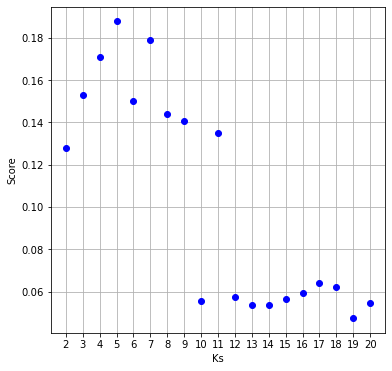

Best value for k with a score of 0.1876798432523653 is 5.


In [53]:
plt.figure(figsize = (6, 6))
line = np.array(sil)
plt.xlabel("Ks")
plt.ylabel("Score")
plt.plot(line, "ro", color = "b", linewidth = 1.0)
plt.grid()
plt.xticks(np.arange(len(line)), np.arange(2, len(line) + 2))
plt.show()
print("Best value for k with a score of {} is {}.".format(max(sil),sil.index(max(sil)) + 2))

In [54]:
k_opt = sil.index(max(sil)) + 2
kclusters = k_opt
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(berlin_grouped_clustering)
kmeans.labels_[0:10]

array([1, 1, 1, 2, 0, 1, 1, 1, 1, 1])

In [55]:
neighborhoods_venues_sorted.insert(0, "Cluster Labels", kmeans.labels_)

In [56]:
berlin_merged = berlin.join(neighborhoods_venues_sorted.set_index("Neighborhood"), on = "Neighborhood")
berlin_merged = pd.merge(berlin_merged, berlin_borough, on = "Borough", how = "left")
berlin_merged_columns = list(berlin_merged.columns[:2]) + list(berlin_merged.columns[-4:]) + list(berlin_merged.columns[2:-4])
berlin_merged = berlin_merged[berlin_merged_columns]

In [57]:
berlin_merged.loc[berlin_merged["Cluster Labels"].isna(), :]

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,fill_color,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Grunewald,Charlottenburg-Wilmersdorf,4856.0,343592.0,1.41,0.61,52.460482,13.238699,black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,Rahnsdorf,Treptow-Koepenick,NaN,NaN,NaN,NaN,52.435873,13.701802,darkpurple,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
berlin_merged = berlin_merged.loc[berlin_merged["Cluster Labels"].notna(), :]
berlin_merged.reset_index(drop = True, inplace = True)
berlin_merged["Cluster Labels"] = berlin_merged["Cluster Labels"].astype(int)

In [59]:
berlin_merged = remove_umlaute(berlin_merged)

In [60]:
berlin_merged.sort_values("Price", ascending = True, inplace = True)

In [61]:
pd.DataFrame(berlin_merged["Cluster Labels"].value_counts()).sort_index()

,Cluster Labels
0,16
1,74
2,1
3,1
4,2


In [62]:
map_berlin_2 = folium.Map(location=[get_coordinates("Berlin, Germany")[0], get_coordinates("Berlin, Germany")[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, neigh, borough, cluster, price, people, color in zip(berlin_merged['Latitude'], berlin_merged['Longitude'], berlin_merged['Neighborhood'], berlin_merged["Borough"], berlin_merged['Cluster Labels'], berlin_merged["Price_Scaled"], berlin_merged["People_Scaled"], berlin_merged["fill_color"]):

    folium.CircleMarker(
        location = [lat, lon],
        radius=10,
        color=rainbow[cluster - 1],
        fill=True,
        fill_opacity=0.7).add_to(map_berlin_2)

    folium.Marker(
        location = [lat, lon],
        icon = folium.Icon(color = color),
        popup = "{}, {}, {}, {}, {}".format(neigh, borough, cluster ,price, people)).add_to(map_berlin_2)
       
map_berlin_2

In [63]:
berlin_0 = berlin_merged.loc[berlin_merged["Cluster Labels"] == 0, :]

In [67]:
berlin_1 = berlin_merged.loc[berlin_merged["Cluster Labels"] == 1, :]

In [64]:
def set_icon(df, icon_1, icon_2, icon_3):
    df["icon"] = np.nan
    df["icon"][:5] = icon_1
    df["icon"][-5:] = icon_2
    df.loc[df["icon"].isna(), "icon"] = icon_3

    return(df)

In [65]:
berlin_0 = set_icon(berlin_0, "star", "euro", "info")

In [68]:
berlin_1 = set_icon(berlin_1, "star", "euro", "info")

In [69]:
map_berlin_3 = folium.Map(location=[get_coordinates("Berlin, Germany")[0], get_coordinates("Berlin, Germany")[1]], zoom_start=11)

for lat, lon, neigh, borough, cluster, price, people, color, icon in zip(berlin_0['Latitude'], berlin_0['Longitude'], berlin_0['Neighborhood'], berlin_0["Borough"], berlin_0['Cluster Labels'], berlin_0["Price_Scaled"], berlin_0["People_Scaled"], berlin_0["fill_color"], berlin_0["icon"]):

    folium.Marker(
        location = [lat, lon],
        icon = folium.Icon(color = color, icon = icon, prefix = "fa"),
        popup = "{}, {}, {}, {}, {}".format(neigh, borough, cluster ,price, people)).add_to(map_berlin_3)
       
map_berlin_3

In [70]:
berlin_0[:5]

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,fill_color,Cluster Labels,...,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,icon
20,Kaulsdorf,Marzahn-Hellersdorf,2500.0,269967.0,-1.67,-0.91,52.510132,13.580990,purple,0,...,Hotel,Park,Light Rail Station,Plaza,Event Service,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant,star
58,Falkenhagener-Feld,Spandau,2751.0,245197.0,-1.34,-1.42,52.552403,13.166894,darkblue,0,...,Snack Place,Drugstore,Chinese Restaurant,Zoo Exhibit,Ethiopian Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,star
51,Konradshoehe,Reinickendorf,3053.0,266408.0,-0.94,-0.98,52.585684,13.223198,beige,0,...,Restaurant,Supermarket,Bus Stop,Farmers Market,Event Service,Event Space,Falafel Restaurant,Farm,Zoo Exhibit,star
17,Wartenberg,Lichtenberg,3585.0,294201.0,-0.25,-0.41,52.575395,13.517582,green,0,...,Spa,Soccer Field,Supermarket,German Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,star
11,Friedrichsfelde,Lichtenberg,3585.0,294201.0,-0.25,-0.41,52.502936,13.520546,green,0,...,Zoo Exhibit,Gastropub,Hotel,Drugstore,Café,Tram Station,Cafeteria,Palace,Falafel Restaurant,star


In [71]:
berlin_0[-5:]

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,fill_color,Cluster Labels,...,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,icon
1,Charlottenburg-Nord,Charlottenburg-Wilmersdorf,4856.0,343592.0,1.41,0.61,52.540525,13.296266,black,0,...,Rock Climbing Spot,Soccer Field,Plaza,Post Office,Falafel Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,euro
30,Buckow,Neukoelln,NaN,NaN,NaN,NaN,52.418662,13.428950,darkred,0,...,Miscellaneous Shop,Pizza Place,Currywurst Joint,Event Service,Fountain,Food Court,Food & Drink Shop,Flower Shop,Cupcake Shop,euro
75,Lichtenrade,Tempelhof-Schoeneberg,NaN,NaN,NaN,NaN,52.393456,13.402040,cadetblue,0,...,Supermarket,Bus Stop,Doner Restaurant,Zoo Exhibit,Ethiopian Restaurant,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,euro
83,Baumschulenweg,Treptow-Koepenick,NaN,NaN,NaN,NaN,52.461694,13.481548,darkpurple,0,...,Ice Cream Shop,Drugstore,Asian Restaurant,Fast Food Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fish Market,euro
92,Plaenterwald,Treptow-Koepenick,NaN,NaN,NaN,NaN,52.479544,13.478808,darkpurple,0,...,Supermarket,Light Rail Station,Zoo Exhibit,French Restaurant,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,euro


In [72]:
map_berlin_4 = folium.Map(location=[get_coordinates("Berlin, Germany")[0], get_coordinates("Berlin, Germany")[1]], zoom_start=11)

for lat, lon, neigh, borough, cluster, price, people, color, icon in zip(berlin_1['Latitude'], berlin_1['Longitude'], berlin_1['Neighborhood'], berlin_1["Borough"], berlin_1['Cluster Labels'], berlin_1["Price_Scaled"], berlin_1["People_Scaled"], berlin_1["fill_color"], berlin_1["icon"]):

    folium.Marker(
        location = [lat, lon],
        icon = folium.Icon(color = color, icon = icon, prefix = "fa"),
        popup = "{}, {}, {}, {}, {}".format(neigh, borough, cluster ,price, people)).add_to(map_berlin_4)
       
map_berlin_4

In [73]:
berlin_1[:5]

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,fill_color,Cluster Labels,...,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,icon
19,Hellersdorf,Marzahn-Hellersdorf,2500.0,269967.0,-1.67,-0.91,52.536854,13.604774,purple,1,...,Indian Restaurant,Climbing Gym,Drugstore,Electronics Store,Sandwich Place,Multiplex,Shoe Store,Shopping Mall,Big Box Store,star
18,Biesdorf,Marzahn-Hellersdorf,2500.0,269967.0,-1.67,-0.91,52.510992,13.555013,purple,1,...,Big Box Store,Miscellaneous Shop,Light Rail Station,Palace,Park,Plaza,Fish Market,Fish & Chips Shop,Event Service,star
21,Mahlsdorf,Marzahn-Hellersdorf,2500.0,269967.0,-1.67,-0.91,52.508699,13.613162,purple,1,...,Automotive Shop,Tram Station,Motorcycle Shop,Gym / Fitness Center,IT Services,Light Rail Station,Supermarket,Cosmetics Shop,Furniture / Home Store,star
22,Marzahn,Marzahn-Hellersdorf,2500.0,269967.0,-1.67,-0.91,52.542948,13.563142,purple,1,...,German Restaurant,Tram Station,Gas Station,Asian Restaurant,Liquor Store,Zoo Exhibit,Farm,Event Space,Falafel Restaurant,star
59,Gatow,Spandau,2751.0,245197.0,-1.34,-1.42,52.485641,13.180134,darkblue,1,...,Hotel,Bathing Area,Bus Stop,Italian Restaurant,Harbor / Marina,Supermarket,Zoo Exhibit,Event Space,Falafel Restaurant,star


In [74]:
berlin_1[-5:]

,Neighborhood,Borough,Price,People,Price_Scaled,People_Scaled,Latitude,Longitude,fill_color,Cluster Labels,...,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,icon
88,Koepenick,Treptow-Koepenick,NaN,NaN,NaN,NaN,52.453910,13.576413,darkpurple,1,...,Drugstore,Indian Restaurant,Sporting Goods Shop,Burger Joint,German Restaurant,Bank,Bookstore,Electronics Store,Gym / Fitness Center,euro
89,Mueggelheim,Treptow-Koepenick,NaN,NaN,NaN,NaN,52.412165,13.661954,darkpurple,1,...,Café,Event Service,American Restaurant,Harbor / Marina,German Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,euro
90,Niederschoeneweide,Treptow-Koepenick,NaN,NaN,NaN,NaN,52.454820,13.517877,darkpurple,1,...,Italian Restaurant,Fast Food Restaurant,Gas Station,Beach,Restaurant,Greek Restaurant,Tram Station,Harbor / Marina,Motel,euro
91,Oberschoeneweide,Treptow-Koepenick,NaN,NaN,NaN,NaN,52.462456,13.523476,darkpurple,1,...,Burger Joint,Supermarket,Food & Drink Shop,Bakery,German Restaurant,Falafel Restaurant,History Museum,Asian Restaurant,Pizza Place,euro
93,Schmoeckwitz,Treptow-Koepenick,NaN,NaN,NaN,NaN,52.375665,13.648855,darkpurple,1,...,Ice Cream Shop,Tram Station,Gas Station,Italian Restaurant,Farmers Market,Event Service,Event Space,Falafel Restaurant,Farm,euro
